In [1]:
import os 
import numpy as np 
import torch 
import time
import timm

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim #for gradient descent

# alexnet
import torchvision.models

import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt

C:\Users\jiaxz\anaconda3\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'C:\Users\jiaxz\anaconda3\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


In [2]:
data_dir = 'C:/Users/jiaxz/Desktop/grad/2022_winter/eecs545/Project/Snake_Images/'
train_dir = os.path.join(data_dir,'train/')
test_dir = os.path.join(data_dir,'test/')


classes = ["Non_Venomous" , "Venomous"]
data_transform = transforms.Compose([transforms.Resize([224,224]), transforms.ToTensor()])
train_data = datasets.ImageFolder(train_dir, transform = data_transform)
test_data = datasets.ImageFolder(test_dir, transform = data_transform)

print('Num training images' , len(train_data))  # it opens up all the images in the folder
print('Num test images', len(test_data))

Num training images 1775
Num test images 192


In [3]:
examples = enumerate(test_data)
index, (img, label)=next(examples)

In [4]:
index, img, label  # it shows one batch of the data

(0,
 tensor([[[0.2667, 0.2392, 0.2431,  ..., 0.2980, 0.2980, 0.2902],
          [0.2471, 0.2353, 0.2431,  ..., 0.2980, 0.2510, 0.2627],
          [0.2275, 0.2275, 0.2510,  ..., 0.2745, 0.2196, 0.2235],
          ...,
          [0.1137, 0.1020, 0.1020,  ..., 0.2157, 0.2235, 0.3412],
          [0.0784, 0.1059, 0.0941,  ..., 0.2118, 0.2235, 0.4196],
          [0.1059, 0.1176, 0.1020,  ..., 0.1922, 0.2039, 0.2627]],
 
         [[0.3608, 0.3333, 0.3255,  ..., 0.3843, 0.3686, 0.3529],
          [0.3412, 0.3216, 0.3216,  ..., 0.3882, 0.3255, 0.3294],
          [0.3176, 0.3176, 0.3333,  ..., 0.3686, 0.3098, 0.3059],
          ...,
          [0.1098, 0.0980, 0.1020,  ..., 0.2667, 0.2745, 0.3882],
          [0.0941, 0.1176, 0.1098,  ..., 0.2667, 0.2784, 0.4706],
          [0.1333, 0.1412, 0.1294,  ..., 0.2471, 0.2667, 0.3255]],
 
         [[0.1451, 0.1373, 0.1490,  ..., 0.2078, 0.2275, 0.2275],
          [0.1490, 0.1412, 0.1529,  ..., 0.2039, 0.1686, 0.1882],
          [0.1529, 0.1529, 0.1686,  

(<matplotlib.image.AxesImage at 0x14e85008340>, 0)

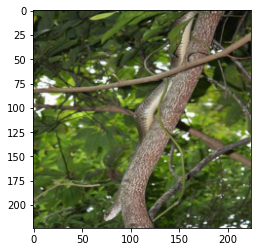

In [5]:
plt.imshow(img.T) , label

In [6]:
batch_size = 36

train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size, shuffle = True)

<ipython-input-7-82b2ddc7ad6d>:11: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])


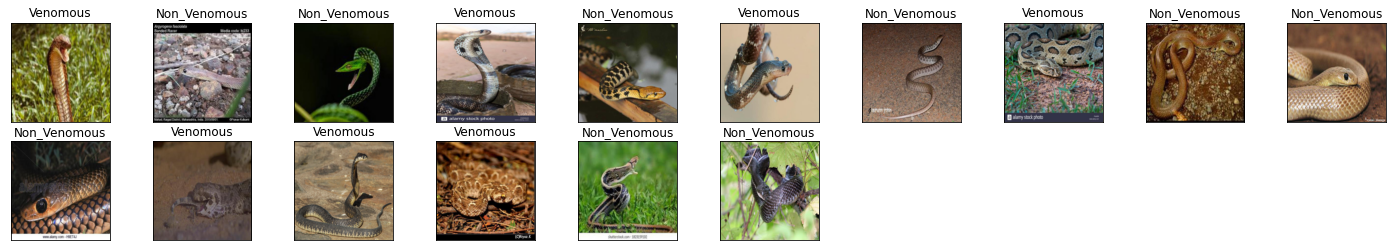

In [7]:
# Visualize some sample data

# obtain one batch of training images
dataiter = iter(train_loader)   # get the image from train_loader
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(16):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

In [8]:
model = timm.create_model('regnety_002', pretrained=True)
model

RegNet(
  (stem): ConvBnAct(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (act): ReLU(inplace=True)
    )
  )
  (s1): RegStage(
    (b1): Bottleneck(
      (conv1): ConvBnAct(
        (conv): Conv2d(32, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNormAct2d(
          24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (act): ReLU(inplace=True)
        )
      )
      (conv2): ConvBnAct(
        (conv): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=3, bias=False)
        (bn): BatchNormAct2d(
          24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (act): ReLU(inplace=True)
        )
      )
      (se): SEModule(
        (fc1): Conv2d(24, 8, kernel_size=(1, 1), stride=(1, 1))
        (bn): Identity()
        (act): ReLU(inplace=True)


In [11]:
def get_accuracy(model,small_loader):
    
    data_loader = small_loader


    correct = 0
    total = 0
    for imgs, labels in data_loader:
        
         
        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        #############################################
        
        
        output = model(imgs)
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1] # predication to find how many is correct
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [12]:
model.cuda()

RegNet(
  (stem): ConvBnAct(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (act): ReLU(inplace=True)
    )
  )
  (s1): RegStage(
    (b1): Bottleneck(
      (conv1): ConvBnAct(
        (conv): Conv2d(32, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNormAct2d(
          24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (act): ReLU(inplace=True)
        )
      )
      (conv2): ConvBnAct(
        (conv): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=3, bias=False)
        (bn): BatchNormAct2d(
          24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (act): ReLU(inplace=True)
        )
      )
      (se): SEModule(
        (fc1): Conv2d(24, 8, kernel_size=(1, 1), stride=(1, 1))
        (bn): Identity()
        (act): ReLU(inplace=True)


# testing on the model using single image

<ipython-input-13-0fb7472bb997>:11: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])


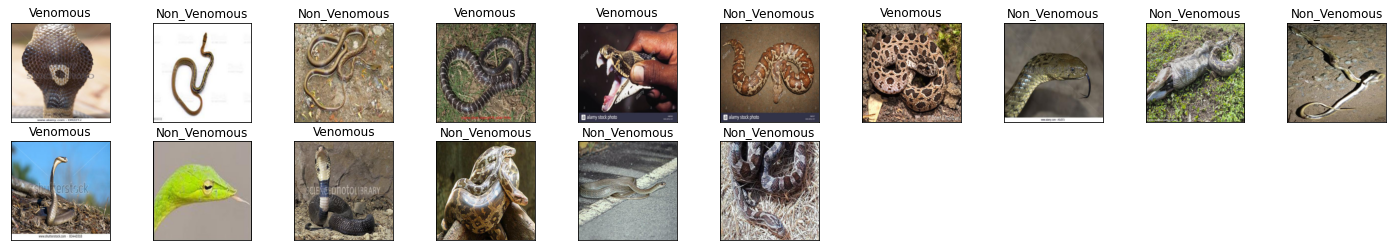

In [13]:
# Visualize some sample data
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, shuffle = True)
# obtain one batch of training images
dataiter = iter(train_loader)   # get the image from train_loader
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(16):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

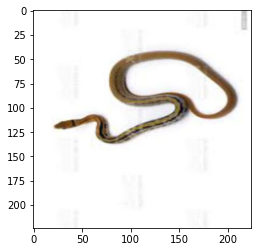

In [14]:
images[1],labels[1]
plt.imshow(images[1].T)

In [15]:
one_batch =  iter(train_loader)
imgs, label = one_batch.next()

In [16]:
imgs = imgs.cuda()
out = model(imgs)
out.shape

torch.Size([36, 1000])

In [17]:
nn.CrossEntropyLoss?

In [18]:
# fully connected layer
class RegnetY_fc(nn.Module):
    def __init__(self):
        super(RegnetY_fc,self).__init__()
        self.regnety=timm.create_model('regnety_002', pretrained=True)
        self.fc1 = nn.Linear(1000, 256) # the ouput image size is 256*6*6, batch size was eliminated as shown before 
        self.fc2 = nn.Linear(256, 128) # Hidden units = 128
        self.fc3 = nn.Linear(128, 32) # Hidden units = 32
        self.fc4 = nn.Linear(32, 2)
        self.dropout=nn.Dropout(p=0.5) #This could be used to test Dropout

    def forward(self, x):
        x=self.regnety(x)
        x = x.view(-1, 1000) #flatten feature data
        x = F.relu(self.fc1(x))
        #x = self.dropout(x) used to test drop out, the location could be changed
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [19]:
snakeModel = RegnetY_fc()

In [20]:
model_parameters = sum(p.numel() for p in snakeModel.parameters() if p.requires_grad)
model_parameters

3456342

In [21]:
snakeModel = snakeModel.cuda()
outAnn = snakeModel(imgs)
outAnn

tensor([[ 0.1836, -0.1066],
        [ 0.2159,  0.0855],
        [ 0.2337, -0.0691],
        [ 0.2582,  0.0081],
        [ 0.2475, -0.1309],
        [ 0.2100, -0.1252],
        [ 0.1941, -0.1319],
        [ 0.1937, -0.0417],
        [ 0.2923, -0.1337],
        [ 0.1453, -0.0017],
        [ 0.3160, -0.1042],
        [ 0.1609, -0.0434],
        [ 0.1398, -0.0761],
        [ 0.2494, -0.0490],
        [ 0.2292, -0.0833],
        [ 0.2276, -0.1387],
        [ 0.1517, -0.0293],
        [ 0.1556, -0.0363],
        [ 0.2919, -0.0564],
        [ 0.0938,  0.0603],
        [ 0.2382, -0.0365],
        [ 0.2272, -0.0868],
        [ 0.2917, -0.1275],
        [ 0.1561, -0.1873],
        [ 0.2604, -0.1019],
        [ 0.2160, -0.0789],
        [ 0.2037, -0.0614],
        [ 0.2418, -0.0600],
        [ 0.2252, -0.0438],
        [ 0.2210, -0.0872],
        [ 0.2566, -0.1861],
        [ 0.2664, -0.1376],
        [ 0.2420, -0.1273],
        [ 0.2164, -0.0869],
        [ 0.1824, -0.0648],
        [ 0.2036, -0

In [22]:
def train(model,data, batch_size=20, num_epochs=1, LR = 0.001):
    small_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True) # batch size is the number of image that you want to process together 
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=LR, momentum=0.9)

    iters, losses, small_acc = [], [], [], [], []
    
    # training
    n = 0 # the number of iterations
    start_time=time.time()
    for epoch in range(num_epochs):
        mini_b=0
        mini_batch_correct = 0
        Mini_batch_total = 0
        for imgs, labels in iter(small_loader):
          
            
            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
                imgs = imgs.cuda()
                labels = labels.cuda()
            #############################################

          #### ALNC is alexNet.features (AlexNet without classifier) ####
          
                        # forward pass
            out = model(imgs)
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch
        n += 1  



        iters.append(n)
        losses.append(float(loss)/batch_size)             # compute *average* loss
        
        small_acc.append(get_accuracy(model,small_loader))
          
            
            


        print ("Epoch %d Finished. " % epoch ,'accuracy',small_acc[epoch],"Time per Epoch: % 6.2f s "% ((time.time()-start_time) / (epoch +1)))


    end_time= time.time()
    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, small_acc, label="Training")
       
    plt.xlabel("Epoch")
    plt.ylabel("trainning Accuracy")
    plt.legend(loc='best')
    plt.show()

    fileName = "Batch_size{}_lr{}_epoch{}_no_aug".format(batch_size,LR,num_epochs)
    torch.save(model.state_dict(),fileName )
    
    print("Final Training Accuracy: {}".format(small_acc[-1]))
    #print("Final Validation Accuracy: {}".format(val_acc[-1]))
    print ("Total time:  % 6.2f s  Time per Epoch: % 6.2f s " % ( (end_time-start_time), ((end_time-start_time) / num_epochs) ))

Epoch 0 Finished.  accuracy 0.7374647887323944 Time per Epoch:  20.79 s 
Epoch 1 Finished.  accuracy 0.8845070422535212 Time per Epoch:  20.25 s 
Epoch 2 Finished.  accuracy 0.9492957746478873 Time per Epoch:  19.99 s 
Epoch 3 Finished.  accuracy 0.9814084507042253 Time per Epoch:  19.99 s 
Epoch 4 Finished.  accuracy 0.9853521126760564 Time per Epoch:  19.77 s 
Epoch 5 Finished.  accuracy 0.9808450704225352 Time per Epoch:  19.64 s 
Epoch 6 Finished.  accuracy 0.9915492957746479 Time per Epoch:  19.67 s 
Epoch 7 Finished.  accuracy 0.9881690140845071 Time per Epoch:  19.60 s 
Epoch 8 Finished.  accuracy 0.9938028169014085 Time per Epoch:  19.52 s 
Epoch 9 Finished.  accuracy 0.9949295774647887 Time per Epoch:  19.48 s 
Epoch 10 Finished.  accuracy 0.9966197183098592 Time per Epoch:  19.52 s 
Epoch 11 Finished.  accuracy 0.9949295774647887 Time per Epoch:  19.53 s 
Epoch 12 Finished.  accuracy 0.9954929577464788 Time per Epoch:  19.51 s 
Epoch 13 Finished.  accuracy 0.9949295774647887 

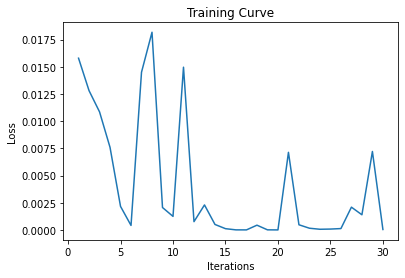

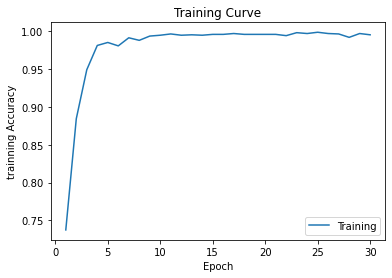

Final Training Accuracy: 0.9954929577464788
Total time:   598.94 s  Time per Epoch:  19.96 s 


In [23]:
use_cuda = True
snakeModel = snakeModel.cuda()
train(snakeModel, train_data,batch_size = 36, num_epochs = 30, LR = 0.005)

In [24]:
dataiter = iter(test_loader)   # get the image from train_loader
images, labels = dataiter.next()

In [25]:
images,labels

(tensor([[[[0.5373, 0.5020, 0.4627,  ..., 0.5725, 0.5255, 0.4706],
           [0.5490, 0.5020, 0.4510,  ..., 0.5961, 0.5569, 0.5059],
           [0.5686, 0.5176, 0.4667,  ..., 0.6235, 0.5922, 0.5529],
           ...,
           [0.5804, 0.5647, 0.4941,  ..., 0.4784, 0.5333, 0.6627],
           [0.5412, 0.4980, 0.4588,  ..., 0.4706, 0.5098, 0.6471],
           [0.4745, 0.4510, 0.4510,  ..., 0.5451, 0.5647, 0.6588]],
 
          [[0.4824, 0.4471, 0.4078,  ..., 0.4784, 0.4431, 0.3882],
           [0.4941, 0.4471, 0.3961,  ..., 0.4980, 0.4706, 0.4235],
           [0.5137, 0.4627, 0.4118,  ..., 0.5216, 0.5020, 0.4667],
           ...,
           [0.5059, 0.4863, 0.4118,  ..., 0.3961, 0.4431, 0.5725],
           [0.4863, 0.4392, 0.3961,  ..., 0.3922, 0.4275, 0.5647],
           [0.4235, 0.3961, 0.3922,  ..., 0.4667, 0.4863, 0.5765]],
 
          [[0.3686, 0.3333, 0.2941,  ..., 0.3451, 0.3216, 0.2745],
           [0.3804, 0.3333, 0.2824,  ..., 0.3647, 0.3490, 0.3059],
           [0.4000, 0.34

In [26]:
pred = snakeModel(images.cuda())

In [27]:
# comparison between the prediction and the actual result
pred = pred.max(1, keepdim=True)[1]
np.squeeze(pred,1),labels

(tensor([0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1,
         1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0], device='cuda:0'),
 tensor([0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1,
         1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0]))

In [28]:
snakeModel.eval()
with torch.no_grad():
    
    test_accuracy_test = get_small_accuracy(snakeModel,test_loader)
    print("test accuracy_test:", test_accuracy_test)

test accuracy_test: 0.8645833333333334
